In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import pickle
import os
from scipy.ndimage import gaussian_filter

plt.rcdefaults()

In [2]:
DATA_PATH = "MHD_data/dataset_pickle"
FILE_EXT = "pickle"


def load_shot(shotno, data_path, file_ext):
    file_path = os.path.join(data_path, f"{shotno}.{file_ext}")
    return pd.read_pickle(file_path)

In [3]:
# get all shot nos
all_shots = [int(os.path.basename(x.split(f".{FILE_EXT}")[0]))
             for x in glob.glob(os.path.join(DATA_PATH, f"*.{FILE_EXT}"))]
if len(all_shots) < 94:  # check if all data is there
    raise ValueError(f"Not all shots found in path /{DATA_PATH}/; found only {len(all_shots)} out of 94")

In [4]:
print(f"List of all shots/pulses:")
print(all_shots)

List of all shots/pulses:
[64374, 64376, 64378, 64389, 64392, 64394, 64401, 64646, 64647, 64648, 64649, 64650, 64658, 64659, 64662, 64664, 64666, 64668, 64670, 64673, 64675, 64677, 64678, 64680, 64682, 64684, 64686, 64770, 64774, 64778, 64820, 64834, 70355, 70356, 70357, 70359, 70380, 70381, 70382, 70383, 70387, 70388, 70389, 70390, 70391, 70392, 70393, 70394, 71182, 71186, 71188, 71189, 71190, 71192, 71193, 71194, 71222, 71223, 71224, 71225, 71226, 71255, 71256, 71259, 71260, 71264, 71265, 71266, 71292, 71300, 71303, 72196, 72198, 72919, 72920, 72925, 72926, 72927, 72928, 72929, 72930, 72959, 72961, 72963, 72964, 72965, 72966, 72967, 73018, 73019, 73020, 73021, 73022, 73023]


In [5]:
shotno = all_shots[3]
#shotno = 71265
data_shot = load_shot(shotno, DATA_PATH, FILE_EXT)

In [6]:
print(f"Example structure of shot #{shotno}:")


def explore_structure(data, indent=0):
    """Recursively prints the structure of nested dictionaries/lists."""
    if isinstance(data, dict):
        for key, value in data.items():
            print('  ' * indent + str(key))
            explore_structure(value, indent + 1)
    elif isinstance(data, list):
        if len(data) > 0:
            print('  ' * indent + f'List of {len(data)} items - showing type of first item')
            explore_structure(data[0], indent + 1)
        else:
            print('  ' * indent + 'Empty List')
    elif isinstance(data, np.ndarray):
        print('  ' * indent + f'NumPy Array - shape: {data.shape}, dtype: {data.dtype}')
    else:
        print('  ' * indent + f'{type(data)}')

explore_structure(data_shot)
data_shot['x']['spectrogram']['OddN'].mean()

Example structure of shot #64389:


In [7]:
# Extracting inputs
inputs = data_shot["x"]["spectrogram"]
spec_even = inputs["EvenN"]
spec_odd = inputs["OddN"]
f = inputs["frequency"]
t = inputs["time"]


# Function to plot spectrogram
def plot_spectrogram(spec, title, time, frequency, start_longest_mode=None, end_longest_mode=None):
    fig, ax = plt.subplots()
    ax.imshow(spec.T, extent=(time[0], time[-1], frequency[0], frequency[-1]), aspect='auto', cmap='jet',
              origin='lower')
    ax.set_xlim(time[0], time[-1])
    ax.set_ylim(frequency[0], frequency[-1])
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Frequency [Hz]")
    fig.set_dpi(150)
    plt.title(title)

    # Plot vertical lines if start and end times are provided
    if start_longest_mode is not None and end_longest_mode is not None:
        ax.axvline(x=start_longest_mode, color='blue', linestyle='--', label='Start of Longest Mode')
        ax.axvline(x=end_longest_mode, color='darkblue', linestyle='--', label='End of Longest Mode')
        plt.legend(loc='upper left')

    plt.show()

In [ ]:
plot_spectrogram(spec_odd, "Odd N", t, f)
plot_spectrogram(spec_even, "Even N", t, f)

0.00042185053347390414


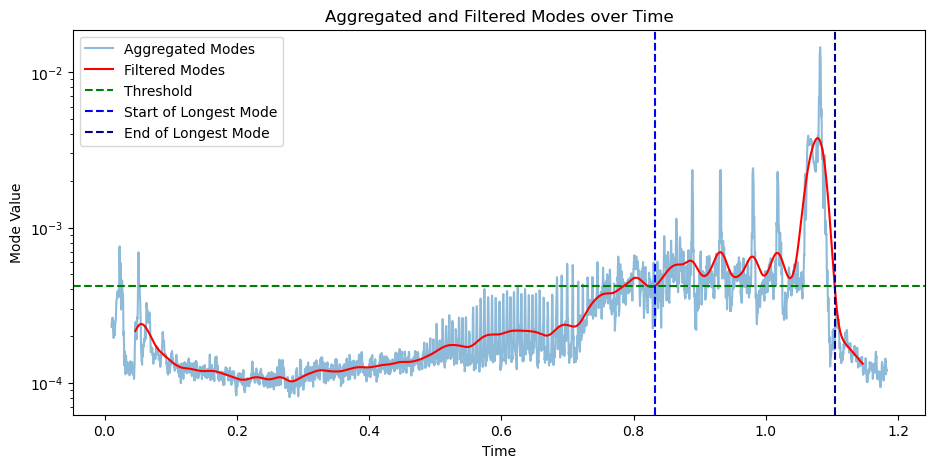

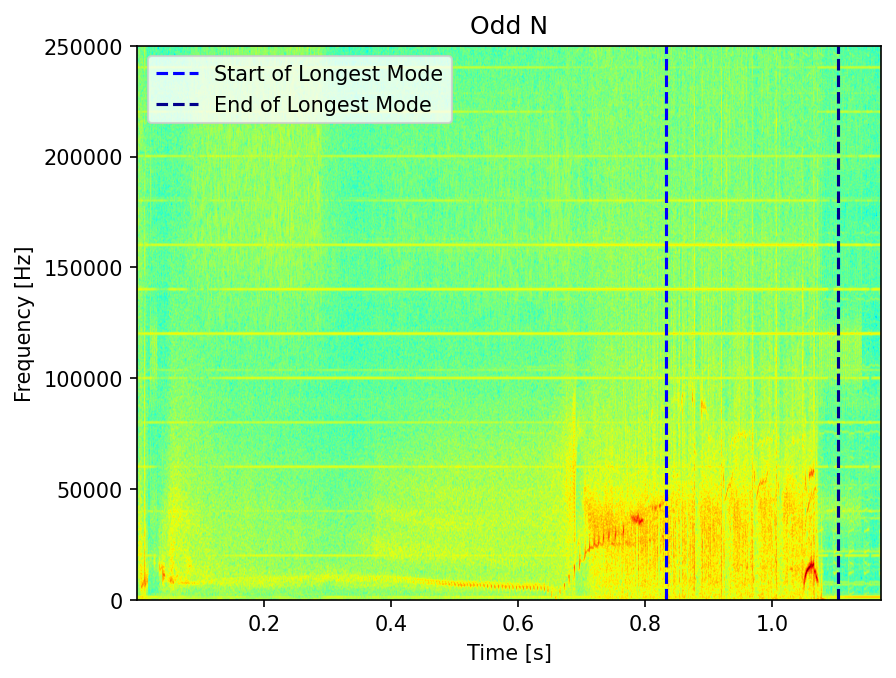

In [9]:
def compute_adaptive_threshold(modes, std_factor, mean_factor):
    if np.all(np.isnan(modes)):
        return np.nan  # Return NaN if all values are NaN
    if np.std(modes) == 0:
        return np.nan  # Return NaN if standard deviation is zero
    mean_val = np.nanmean(modes)  # Use nanmean to ignore NaN values
    std_dev = np.nanstd(modes)  # Use nanstd to ignore NaN values
    
    return mean_factor * mean_val + std_factor * std_dev


def plot_aggregated_modes(label_sources, mode_thresh=0.0005, std_factor=0.25, mean_factor=0.8):
    # Aggregating modes
    modes = np.sum(np.stack([label_sources[f"N{i}"] for i in range(5)]), axis=0) + label_sources["LM"]
    time = label_sources["time"]

    # Applying Gaussian filter
    filtered_modes = gaussian_filter(modes, sigma=45)

    # Calculate adaptive threshold based on the filtered modes
    mode_thresh = compute_adaptive_threshold(filtered_modes, std_factor, mean_factor)
    print(mode_thresh)

    # Find the longest mode segment above the threshold
    above_threshold = filtered_modes > mode_thresh
    change_points = np.diff(above_threshold).nonzero()[0] + 1
    if above_threshold[0]:
        change_points = np.insert(change_points, 0, 0)
    if above_threshold[-1]:
        change_points = np.append(change_points, len(above_threshold))

    segment_lengths = change_points[1::2] - change_points[::2]
    if len(segment_lengths) > 0:
        longest_segment_index = np.argmax(segment_lengths)
        start_longest_mode = time[change_points[2 * longest_segment_index]]
        end_longest_mode = time[change_points[2 * longest_segment_index + 1]]

    # Plotting
    plt.figure(figsize=(11, 5))
    plt.plot(time, modes, label='Aggregated Modes', alpha=0.5)
    plt.plot(time, filtered_modes, label='Filtered Modes', color='red')
    plt.axhline(y=mode_thresh, color='green', linestyle='--', label='Threshold')
    plt.xlabel('Time')
    plt.ylabel('Mode Value')
    plt.title('Aggregated and Filtered Modes over Time')
    plt.yscale('log')

    # Highlight the longest mode segment
    if len(segment_lengths) > 0:
        plt.axvline(x=start_longest_mode, color='blue', linestyle='--', label='Start of Longest Mode')
        plt.axvline(x=end_longest_mode, color='darkblue', linestyle='--', label='End of Longest Mode')

    plt.legend()
    plt.show()

    return (start_longest_mode, end_longest_mode) if len(segment_lengths) > 0 else (None, None)


slm, elm = plot_aggregated_modes(data_shot['y']['modes'])
plot_spectrogram(spec_odd, "Odd N", t, f, slm, elm)

### i

0.0006534651731921367


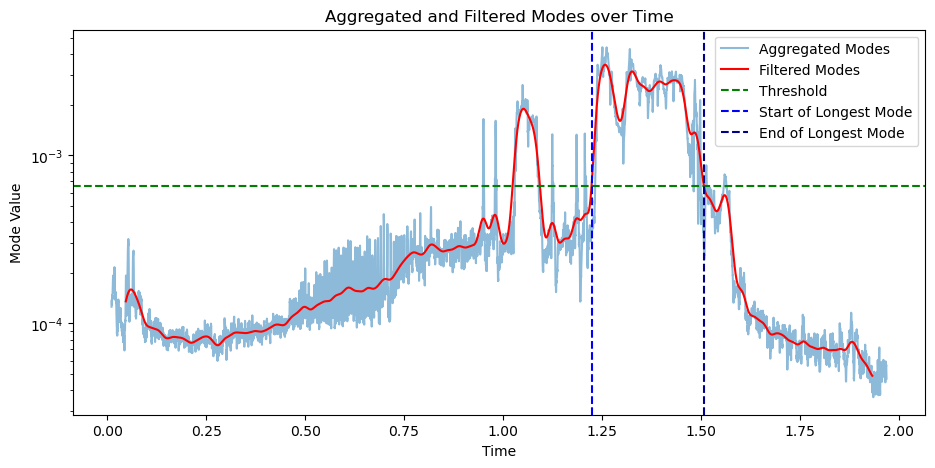

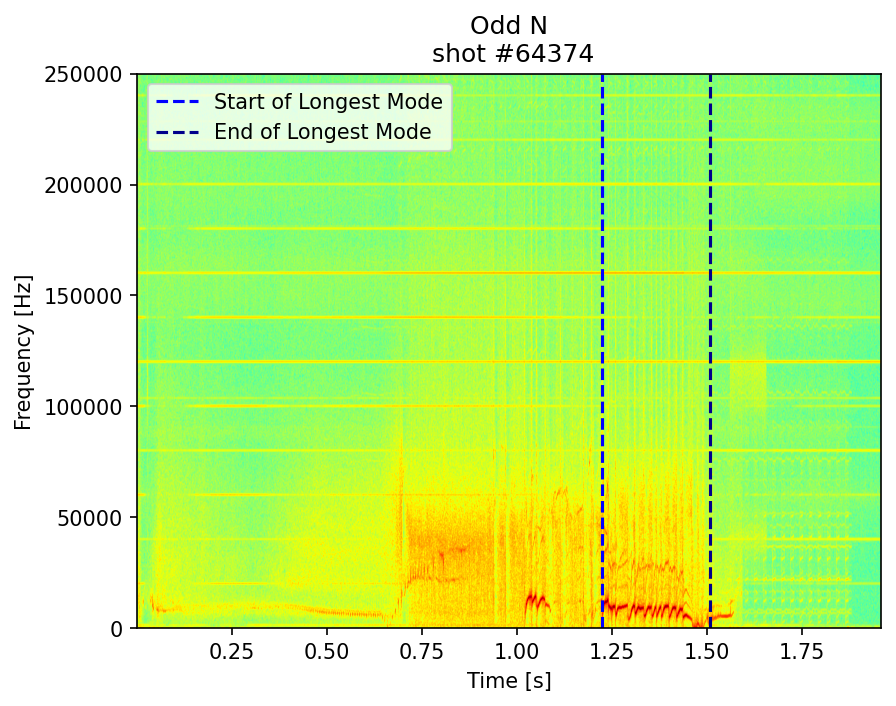

0.0004406824684624223


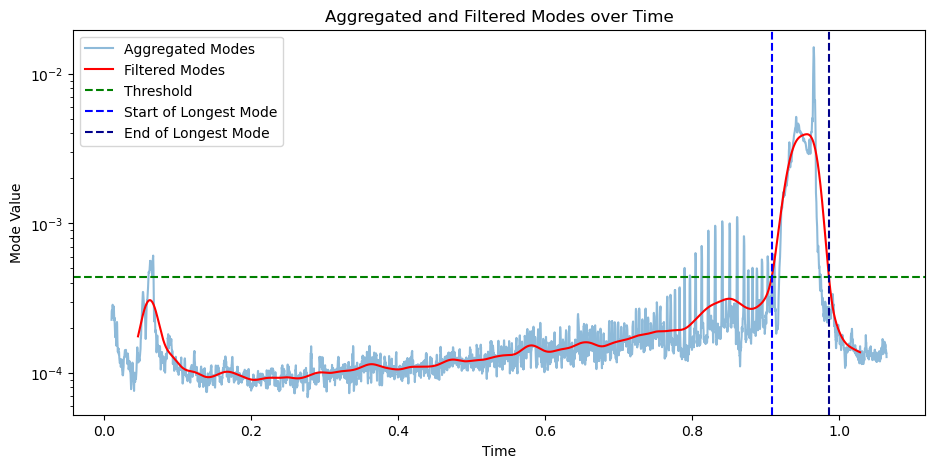

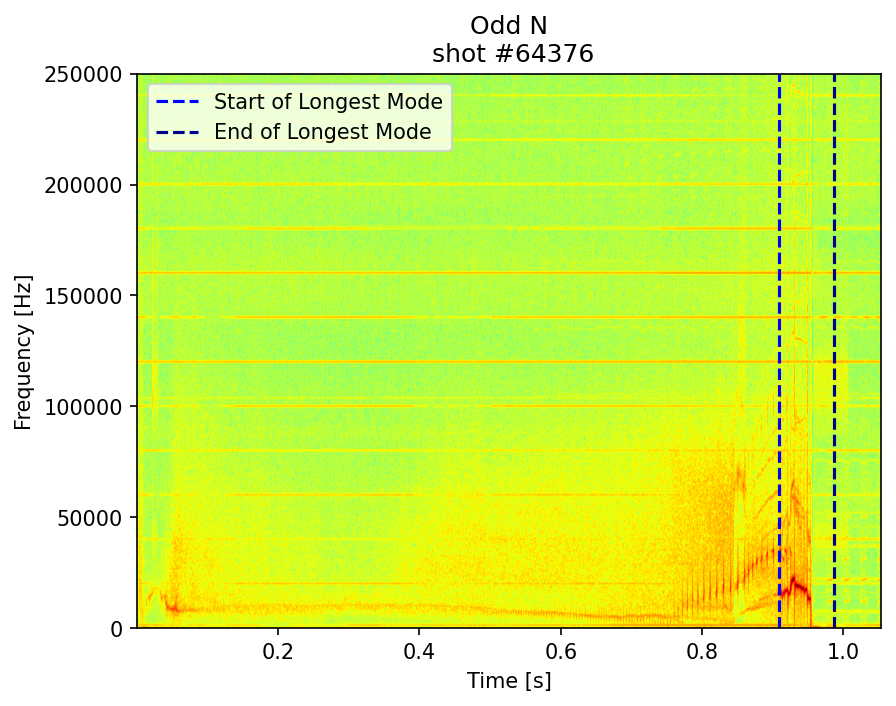

0.00044854202357799905


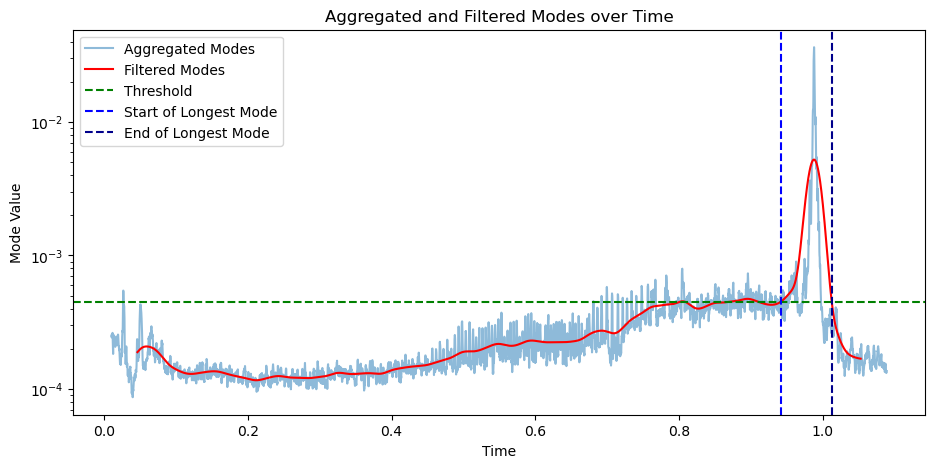

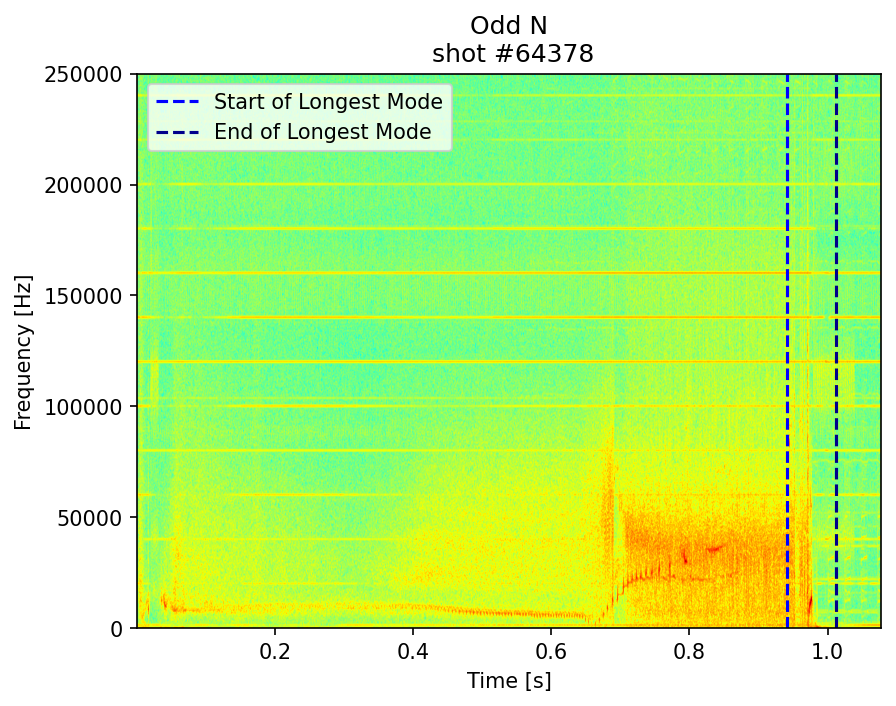

0.00042185053347390414


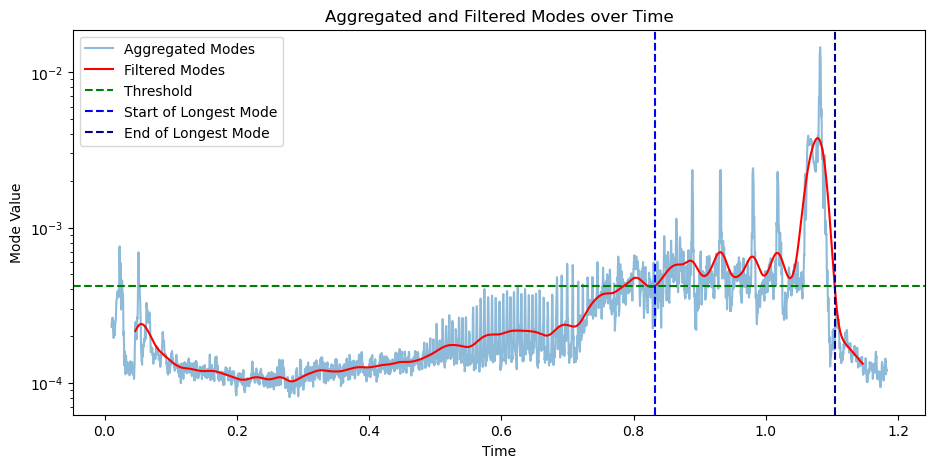

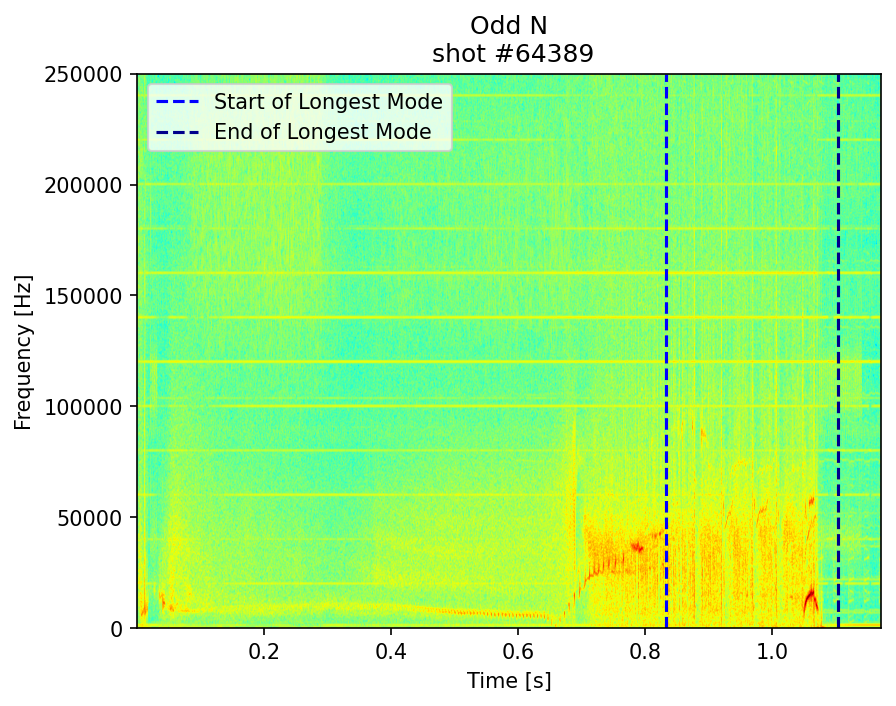

0.0006464324987404417


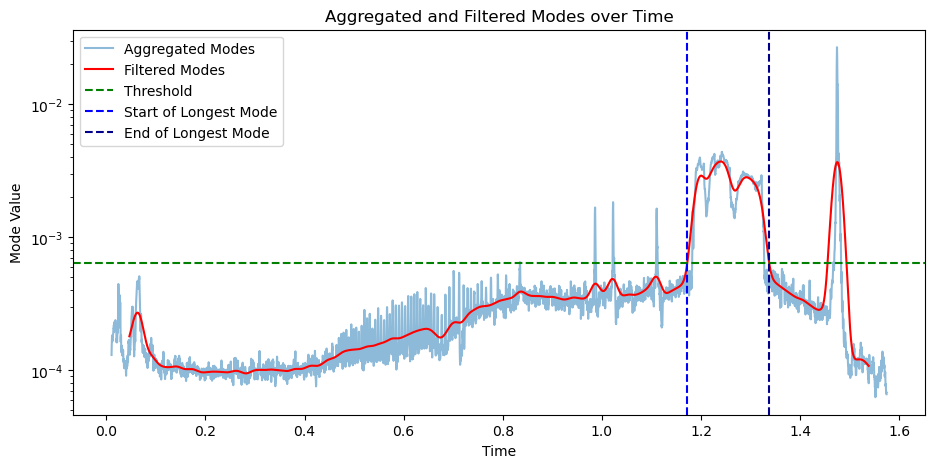

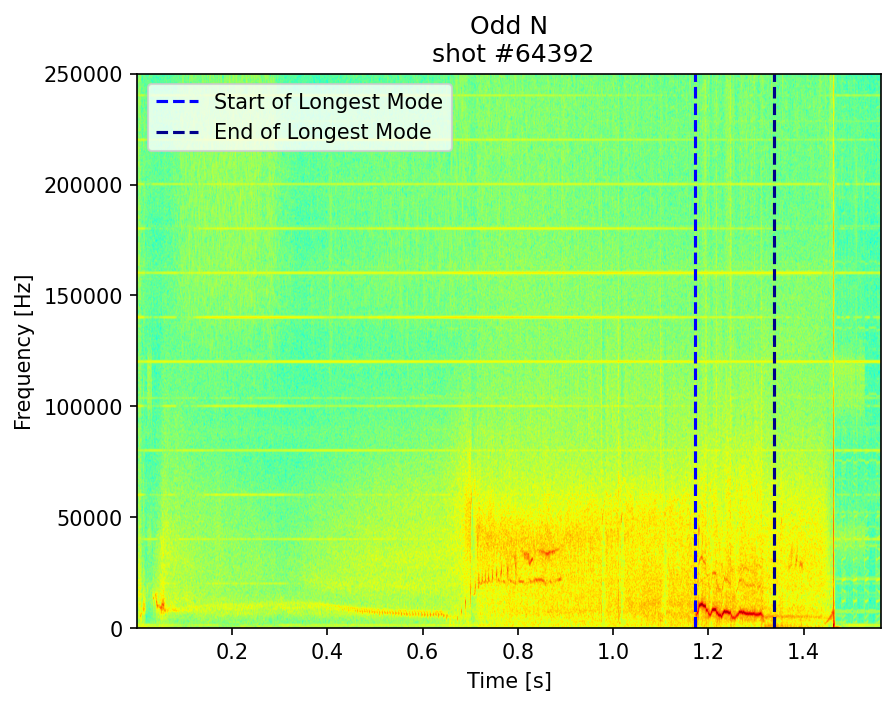

0.0005133101154457649


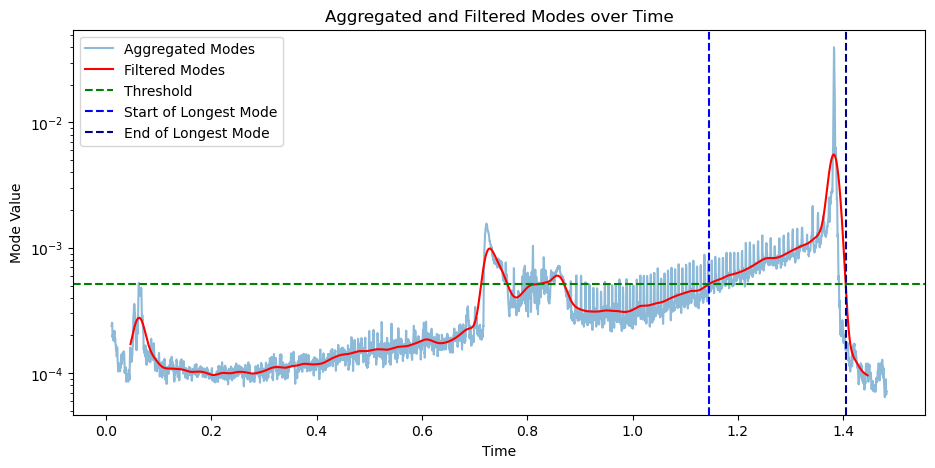

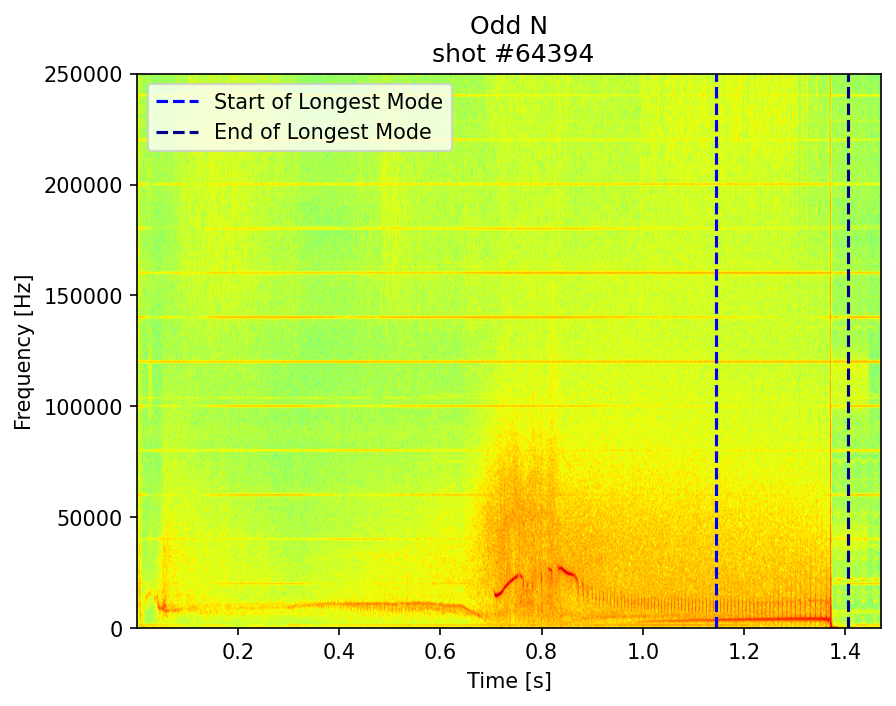

0.0006073033223674857


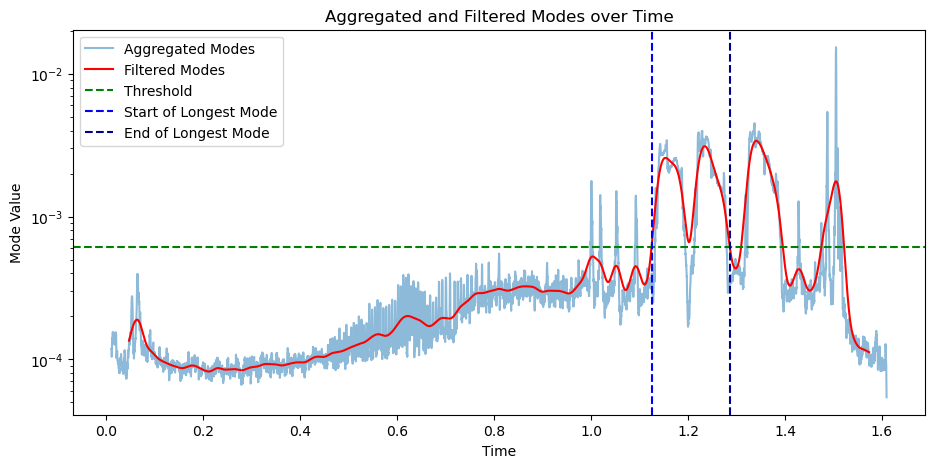

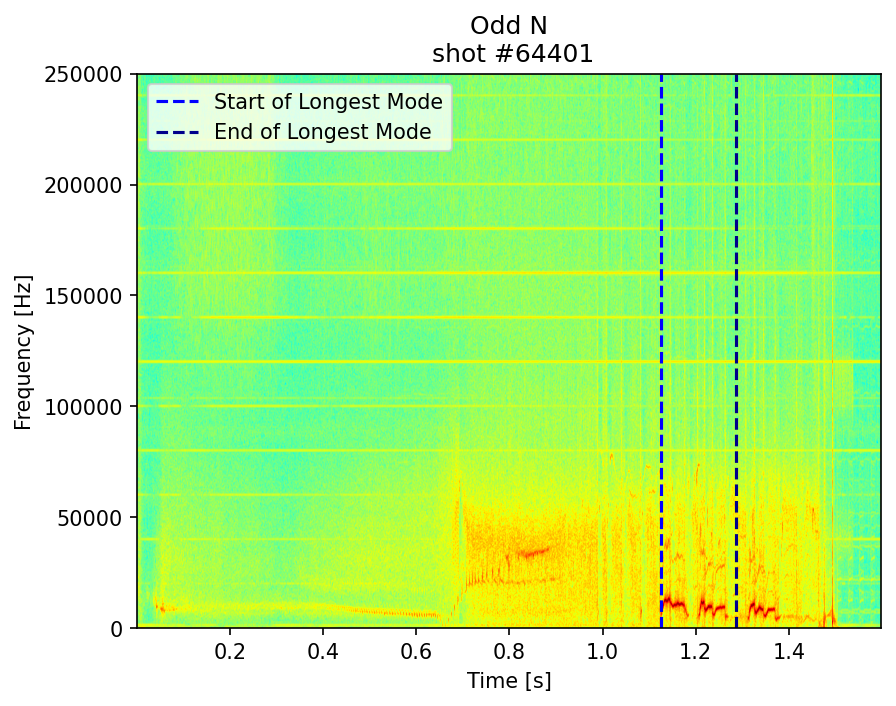

0.00011102051209987356


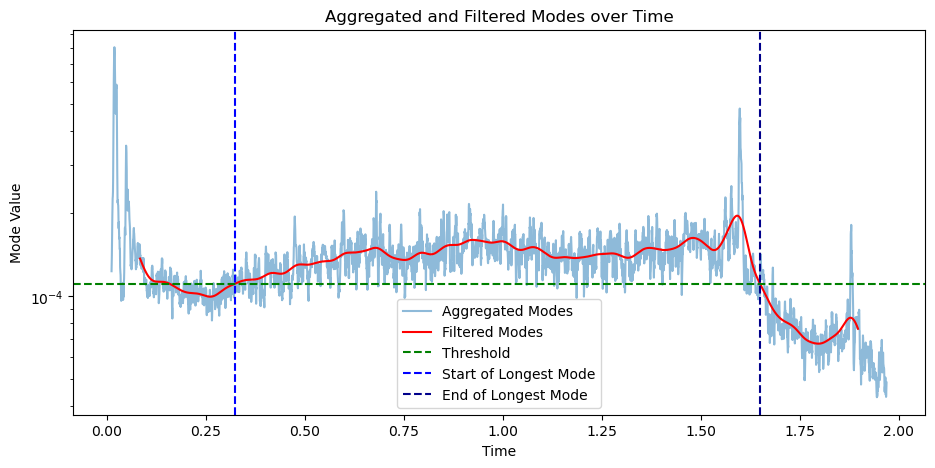

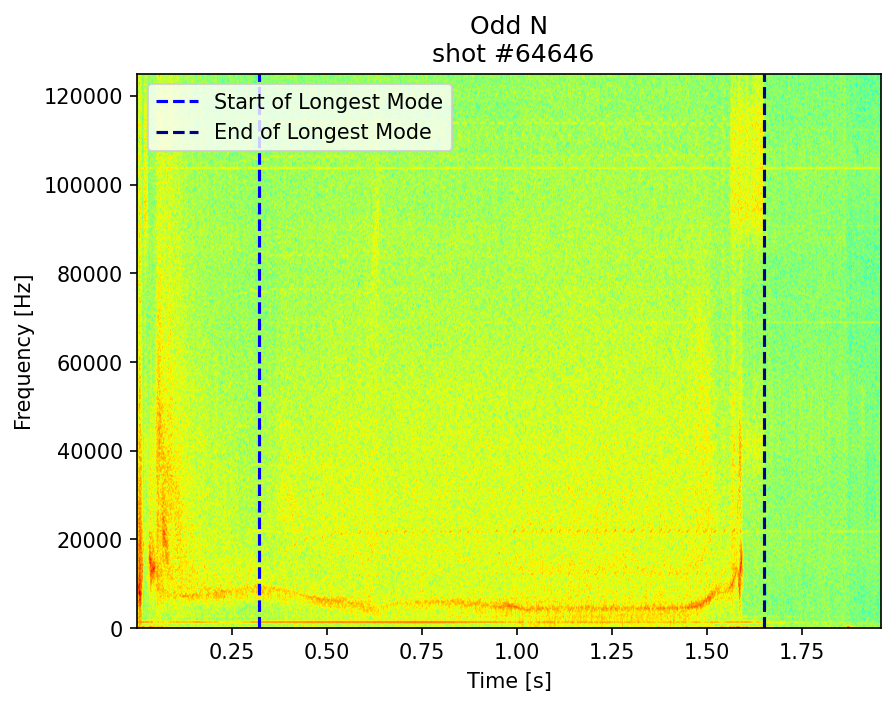

0.00038096368617571597


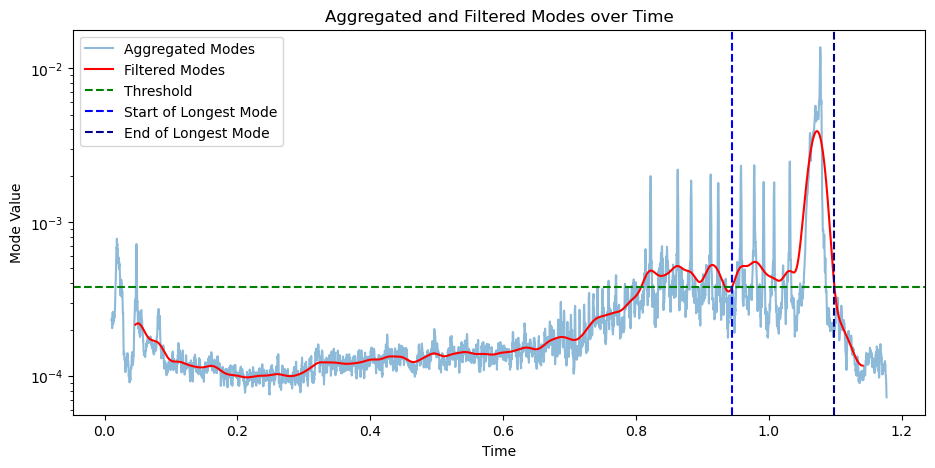

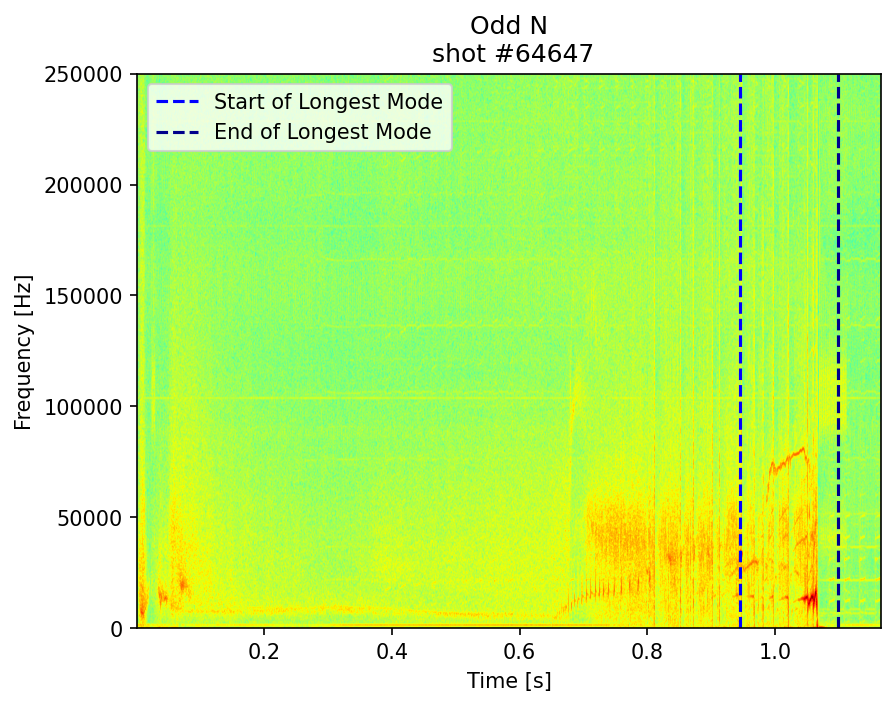

0.00045242500877003


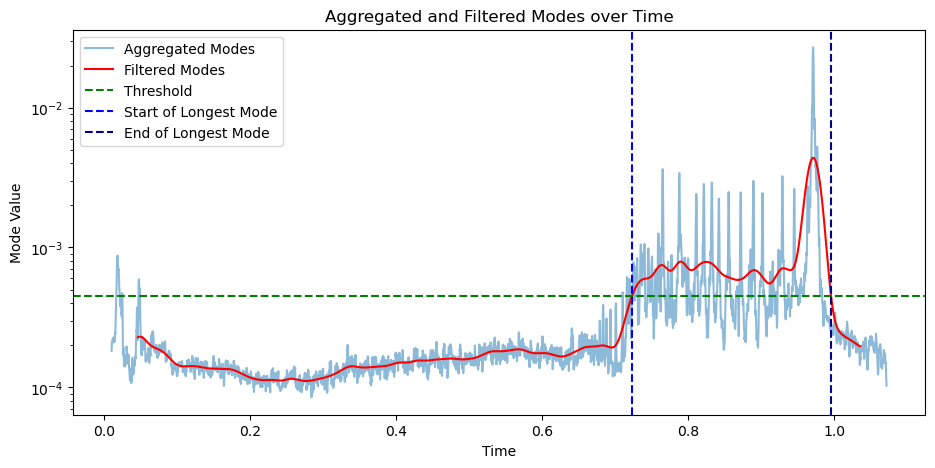

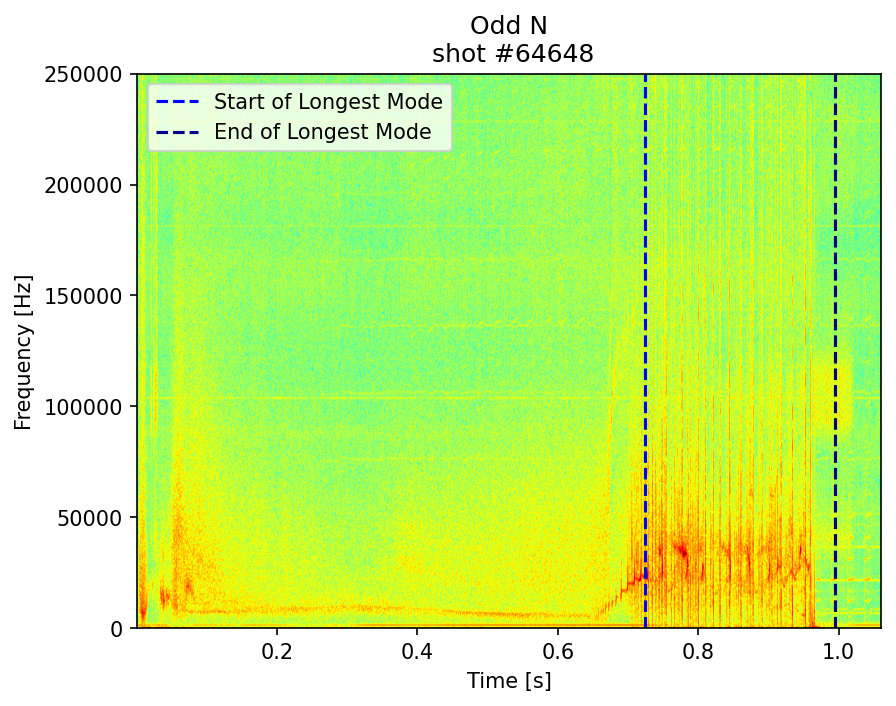

0.00047991511038344525


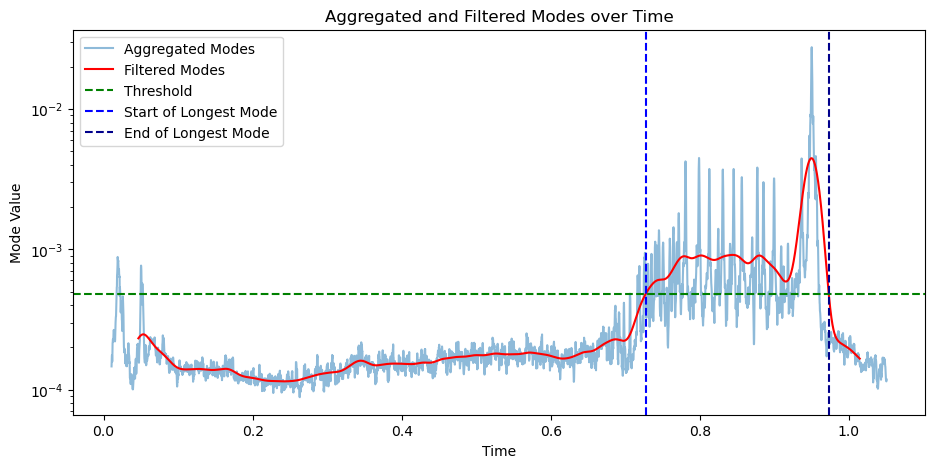

In [ ]:
for shotno in all_shots[:20]:
    data_shot = load_shot(shotno, DATA_PATH, FILE_EXT)
    inputs = data_shot["x"]["spectrogram"]
    spec_odd = inputs["OddN"]
    f = inputs["frequency"]
    t = inputs["time"]

    slm, elm = plot_aggregated_modes(data_shot['y']['modes'], mode_thresh=0.0005)
    plot_spectrogram(spec_odd, f"Odd N\n shot #{shotno}", t, f, slm, elm)